In [1]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ, transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import numpy as np

from math import pi

In [2]:
def get_entropy(labels, base=2):
    value,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

In [3]:
provider = IBMQ.load_account()
#print(provider.backends())
backend = least_busy(provider.backends(simulator=False))
#backend = provider.get_backend('ibmq_armonk')
#backend = provider.get_backend('ibmq_quito')
print(backend)

/Users/edwinagnew/opt/anaconda3/envs/qc/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


ibmq_armonk


In [4]:
from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator.from_backend(backend)

In [5]:
#Comment out to use real device
#from qiskit.test.mock import FakeArmonk
#backend = FakeArmonk()

In [6]:
n = backend.configuration().n_qubits
shots = backend.configuration().max_shots

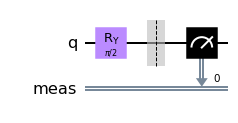

In [7]:
def get_circuit(n, thetas=None):
    if not thetas: thetas = [pi/2] * n
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.ry(thetas[i], i)
    qc.measure_all()
    return qc
qc = get_circuit(n)
qc.draw(output='mpl')

In [8]:
job = execute(qc, backend=simulator, shots=shots)
job_monitor(job)

# Plotting our result
results = job.result().get_counts()
print(results)

Job Status: job has successfully run
{'0': 4020, '1': 4172}


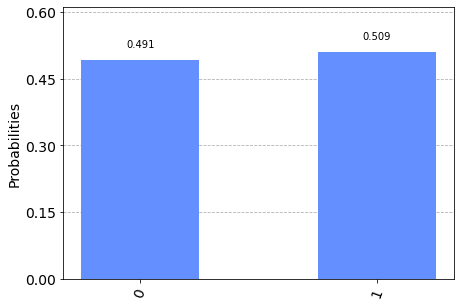

In [9]:
from qiskit.visualization import plot_histogram
plot_histogram(results)

In [10]:
def get_vals(results):
    vals = {}
    for v in results:
        for i, x in enumerate(v):
            if i not in vals: vals[i] = []
            vals[i] += [int(x)] * results[v]
    return vals
            
vals = get_vals(results)
print("0:", len(vals[0]) - sum(vals[0]), "1: ", sum(vals[0]))

0: 4020 1:  4172


In [11]:
backend

<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

In [14]:
#job_manager = IBMQJobManager()
job_manager = None

In [23]:
n_iterations = 15
progress = {j: [] for j in range(n)}
k = 5 # choose k different values of theta for each qubit and compile into k different circuits
best_thetas = [pi/2] * n
delta = 0.01
for iteration in range(n_iterations):
    circs = []
    thetas = []
    for i in range(k):
        diff = i - k//2
        thetas.append([])
        for j in range(n):
            theta = best_thetas[j] + diff * delta
            thetas[i].append(theta)
        circ = get_circuit(n, thetas[i])
        circs.append(circ)
    circs = transpile(circs, backend=backend)
    if job_manager:
        print("\nrunning on job manager...")
        results = job_manager.run(circs, backend=backend, shots=shots).results()
    else:
        print("\nrunning with simulator...")
        results = [execute(c, backend=simulator, shots=shots).result() for c in circs]
    print("\n\n On round", iteration, ": ")
    entropies = {j: (0, 0) for j in range(n)} #stores a tuple which is the best theta for each qubit
    for i in range(k):
        print("\t For theta(s): ", i, thetas[i])
        #print("\t", results.get_counts(i))
        if job_manager:
            vals = get_vals(results.get_counts(i))
        else:
            vals = get_vals(results[i].get_counts())
        differences = {j: sum(vals[j])/len(vals[j]) for j in range(n)}
        print("\t per qubit:", {j: {0: len(vals[j]) - sum(vals[j]), 1: sum(vals[j]), "ratio":differences[j]} for j in range(n)})
        print("\t entropy(s): ", end=", ")
        for j in range(n):
            e = get_entropy(vals[j])
            print(e, end="")
            entropies[j] = max(entropies[j], (e, thetas[i][j]))
        print("\n")
        #x = 1/0 #TODO - decide how to change best_thetas depending on who was the best k
    print("\n updating best_thetas")
    for j in range(n):
        print("qubit", j, "had the best entropy of", entropies[j][0], "at theta=", entropies[j][1])
        best_thetas[j] = entropies[j][1]
        progress[j].append(entropies[j][0])
    #delta /= 2 #change to equation of k?
    delta = delta/((k-1)/2)
    
print("\n\nFinished!: ", entropies)


running with simulator...


 On round 0 : 
	 For theta(s):  0 [1.5507963267948965]
	 per qubit: {0: {0: 4214, 1: 3978, 'ratio': 0.485595703125}}
	 entropy(s): , 0.9994012455550829

	 For theta(s):  1 [1.5607963267948965]
	 per qubit: {0: {0: 4164, 1: 4028, 'ratio': 0.49169921875}}
	 entropy(s): , 0.9998011789221068

	 For theta(s):  2 [1.5707963267948966]
	 per qubit: {0: {0: 4156, 1: 4036, 'ratio': 0.49267578125}}
	 entropy(s): , 0.9998452100782274

	 For theta(s):  3 [1.5807963267948966]
	 per qubit: {0: {0: 4162, 1: 4030, 'ratio': 0.491943359375}}
	 entropy(s): , 0.9998127027878125

	 For theta(s):  4 [1.5907963267948966]
	 per qubit: {0: {0: 4035, 1: 4157, 'ratio': 0.5074462890625}}
	 entropy(s): , 0.9998400072246256


 updating best_thetas
qubit 0 had the best entropy of 0.9998452100782274 at theta= 1.5707963267948966

running with simulator...


 On round 1 : 
	 For theta(s):  0 [1.5607963267948965]
	 per qubit: {0: {0: 4119, 1: 4073, 'ratio': 0.4971923828125}}
	 entropy(s): , 0


running with simulator...


 On round 10 : 
	 For theta(s):  0 [1.5797807017948968]
	 per qubit: {0: {0: 4072, 1: 4120, 'ratio': 0.5029296875}}
	 entropy(s): , 0.9999752343565644

	 For theta(s):  1 [1.5797904674198968]
	 per qubit: {0: {0: 4085, 1: 4107, 'ratio': 0.5013427734375}}
	 entropy(s): , 0.9999947975185579

	 For theta(s):  2 [1.5798002330448968]
	 per qubit: {0: {0: 4132, 1: 4060, 'ratio': 0.49560546875}}
	 entropy(s): , 0.9999442769036948

	 For theta(s):  3 [1.5798099986698968]
	 per qubit: {0: {0: 4127, 1: 4065, 'ratio': 0.4962158203125}}
	 entropy(s): , 0.9999586807736636

	 For theta(s):  4 [1.5798197642948968]
	 per qubit: {0: {0: 4065, 1: 4127, 'ratio': 0.5037841796875}}
	 entropy(s): , 0.9999586807736636


 updating best_thetas
qubit 0 had the best entropy of 0.9999947975185579 at theta= 1.5797904674198968

running with simulator...


 On round 11 : 
	 For theta(s):  0 [1.5797807017948968]
	 per qubit: {0: {0: 4066, 1: 4126, 'ratio': 0.503662109375}}
	 entropy(s): ,

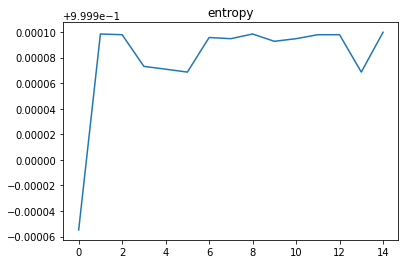

In [24]:
import matplotlib.pyplot as plt

if n > 1:  
    figs, axs = plt.subplots(round(n/2) + 1, 2, figsize=(10, 10))

    for i in range(n):
        axs[i//2, i%2].plot(range(n_iterations), progress[i])
        axs[i//2, i%2].set_xlabel("iterations")
        axs[i//2, i%2].set_ylabel("entropy")
        axs[i//2, i%2].set_title("Entropy for qubit " + str(i))

else:
    plt.plot(range(n_iterations), progress[0])
    plt.title("entropy")


### Algorithm

- For each qubit:
    - Measure k different states each prepared with ry rotation thetas +- k//2 delta
    - Calculate entropy 
    - Choose the best theta value and "zoom in" by reducing delta

Questions:

1. Does it change order of qubits when compiling?
2. Is there way to not have to run it each time? E.g. noise model but identical. Note that job manager does not support fake backends